# Default Credit Card Project

## Jeremy Locatelli, Erik Ring-Walters, Andrea Cano

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Introduction
blah blah blah FIller


In [11]:
dat = pd.read_csv('default_cc_train.csv')

In [35]:
sns.set(rc={'axes.facecolor':'#e0fffa', 'figure.facecolor':'white'})

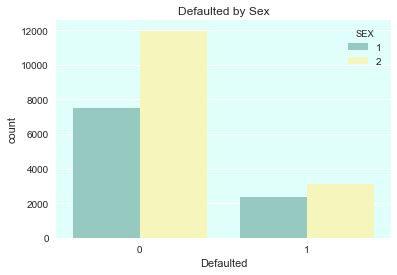

In [36]:
sns.countplot("default.payment.next.month", data = dat, hue = "SEX",palette="Set3")
plt.title("Defaulted by Sex")
plt.xlabel("Defaulted");


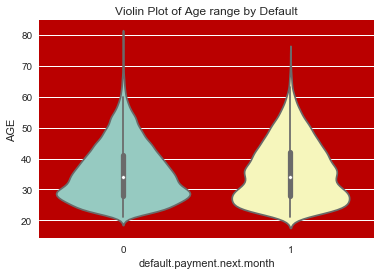

In [34]:
sns.violinplot("default.payment.next.month","AGE", data = dat,palette="Set3")
plt.title("Violin Plot of Age range by Default");


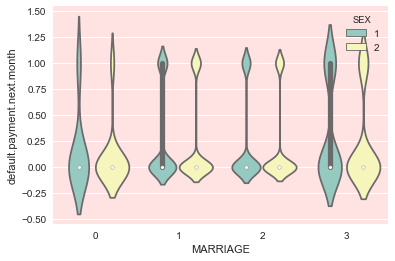

In [30]:
violin = sns.violinplot(x="MARRIAGE",y="default.payment.next.month", hue="SEX", data=dat, palette="Set3")